In [1]:
import psycopg2
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT

DATABASE = 'projeto_integrador'
USER = 'postgres'
PASSWORD = '19213123'
PORT = '5432'

class DataBase():
    
    def __init__(self, dbname='postgres', user='postgres', password='Postgres2019!', statement_tables=None, port='5432'):
        self.user = user
        self.password = password
        self.statement_tables = statement_tables
        self.dbname = dbname
        self.port = port
        
    def set_connection(self, dbname='postgres'):
        #self.conn = psycopg2.connect("dbname={} user={} password={}".format(dbname, self.user, self.password))
        self.conn = psycopg2.connect("user={} password={} port={}".format(self.user, self.password, self.port))
        self.conn.set_isolation_level(ISOLATION_LEVEL_AUTOCOMMIT)
        self.cursor = self.conn.cursor()
        
    def create_tables(self, statement_tables):
        self.create_database()
        for stm in statement_tables:
            self.cursor.execute("DROP TABLE IF EXISTS {} CASCADE;".format(stm['table_name']))
            self.cursor.execute(stm['create_table'])
        print('OK. Tabelas criadas com sucesso.')
        self.close_connection()
            
    def create_database(self):
        self.set_connection()
        try:
            self.cursor.execute('DROP DATABASE IF EXISTS {};'.format(self.dbname))
            self.cursor.execute('CREATE DATABASE {};'.format(self.dbname))
        except Exception as ex:
            print('Aviso: falha ao recriar o database, provavelmente já existente.')
        self.set_connection(self.dbname)
        
    def close_connection(self):
        self.cursor.close()
        self.cursor.close()

TABLE_CASOS_COVID = "casos_covid"
TABLE_LOCALIZACAO = "localizacao"

CREATE_CASOS_COVID = {
        "table_name": TABLE_CASOS_COVID,
        "create_table": "CREATE TABLE {} (" \
              "idcasos_covid INT PRIMARY KEY," \
              "date VARCHAR(45) NULL," \
              "epidemiological_week INT NULL," \
              "casos_covidcol VARCHAR(45) NULL," \
              "is_last INT NULL," \
              "is_repeated INT NULL," \
              "last_available_confirmed INT NULL," \
              "last_available_confirmed_per_100k_inhabitants NUMERIC(10,2) NULL," \
              "last_available_death_rate VARCHAR(45) NULL," \
              "last_available_deaths VARCHAR(45) NULL," \
              "new_confirmed INT NULL," \
              "new_deaths INT NULL" \
        ")".format(TABLE_CASOS_COVID)
        }
CREATE_LOCALIZACAO = {
        "table_name": TABLE_LOCALIZACAO,
        "create_table": "CREATE TABLE {}(" \
              "city VARCHAR(45) NULL," \
              "city_ibge_code VARCHAR(45) NULL," \
              "estimated_population_2019 INT NULL," \
              "order_for_place VARCHAR(45) NULL," \
              "place_type VARCHAR(45) NULL," \
              "state VARCHAR(45) NULL," \
              "casos_covid_idcasos_covid INT NOT NULL," \
              "CONSTRAINT fk_localização_casos_covid" \
              "  FOREIGN KEY (casos_covid_idcasos_covid)" \
              "  REFERENCES casos_covid (idcasos_covid)" \
            ")".format(TABLE_LOCALIZACAO)
        }

statement_tables = [CREATE_CASOS_COVID, CREATE_LOCALIZACAO]

dataBase = DataBase(dbname=DATABASE, user=USER, password=PASSWORD, port=PORT)
dataBase.create_tables(statement_tables)

OK. Tabelas criadas com sucesso.


In [2]:
import pandas as pd
import psycopg2
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT

DATABASE = 'projeto_integrador'
USER = 'postgres'
PASSWORD = '19213123'
PORT = '5432'
FILE = 'C:\\Users\\bastosl\\Downloads\\covid19_casos_brasil.csv'

class Carregador:

    def __init__(self, dbname='postgres', user='postgres', password='Postgres2019!', statement_tables=None, port='5432'):
        self.user = user
        self.password = password
        self.statement_tables = statement_tables
        self.dbname = dbname
        self.port = port
        
    def set_connection(self, dbname='postgres'):
        #self.conn = psycopg2.connect("dbname={} user={} password={}".format(dbname, self.user, self.password))
        self.conn = psycopg2.connect("user={} password={} port={}".format(self.user, self.password, self.port))
        self.conn.set_isolation_level(ISOLATION_LEVEL_AUTOCOMMIT)
        self.cursor = self.conn.cursor()

    def close_connection(self):
        self.cursor.close()
        self.conn.close()

    def load_table(self, query, tuples):
        self.set_connection()
        try:
            self.cursor.executemany(query, tuples)
            self.conn.commit()
        except (Exception, psycopg2.DatabaseError) as error:
            print("Error: %s" % error)
            self.conn.rollback()
            self.close_connection()
        print('OK. Tabelas carregadas com sucesso.')
        self.close_connection()

df = pd.read_csv(FILE)

dfTrab = df[df['city'].isin(['Curitiba', 'Fortaleza', 'Maceió', 'Recife', 'Rio de Janeiro'])]
dfTrab['idcasos_covid'] = dfTrab.index
dfTrab['casos_covid_idcasos_covid'] = dfTrab['idcasos_covid']

casos_covid = dfTrab[['idcasos_covid', 'date', 'epidemiological_week', 'last_available_date', 'is_last', 'is_repeated', 'last_available_confirmed', 'last_available_confirmed_per_100k_inhabitants', 'last_available_death_rate', 'last_available_deaths', 'new_confirmed', 'new_deaths']]
casos_covid = casos_covid.rename(columns={'last_available_date': 'casos_covidcol'})

localizacao = dfTrab[['city', 'city_ibge_code', 'estimated_population_2019', 'order_for_place', 'place_type', 'state', 'casos_covid_idcasos_covid']]

casos_covid = casos_covid.astype({
    'last_available_death_rate': 'str',
    'last_available_deaths': 'str',
    'is_last':'int64',
    'is_repeated':'int64'
    })

carregador = Carregador(dbname=DATABASE, user=USER, password=PASSWORD, port=PORT)


tuples = [tuple(x) for x in casos_covid.to_numpy()]
cols = ','.join(list(casos_covid.columns))
query  = "INSERT INTO  %s(%s) VALUES(%%s,%%s,%%s,%%s,%%s,%%s,%%s,%%s,%%s,%%s,%%s,%%s)" % ('casos_covid', cols)
carregador.load_table(query, tuples)


tuples = [tuple(x) for x in localizacao.to_numpy()]
cols = ','.join(list(localizacao.columns))
query  = "INSERT INTO  %s(%s) VALUES(%%s,%%s,%%s,%%s,%%s,%%s,%%s)" % ('localizacao', cols)
carregador.load_table(query, tuples)

<ipython-input-2-f4e82bc9d1e6>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfTrab['idcasos_covid'] = dfTrab.index
<ipython-input-2-f4e82bc9d1e6>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfTrab['casos_covid_idcasos_covid'] = dfTrab['idcasos_covid']


OK. Tabelas carregadas com sucesso.
OK. Tabelas carregadas com sucesso.


In [3]:
#Criando tabela em Excel do describe da base
tabela_describe = casos_covid.describe()
print(tabela_describe)
tabela_describe.to_excel('tabela_estatisticas.xlsx')

       idcasos_covid  epidemiological_week     is_last  is_repeated  \
count     621.000000            621.000000  621.000000   621.000000   
mean   109493.644122             19.763285    0.008052     0.035427   
std    108858.557444              5.144086    0.089440     0.185005   
min        25.000000             10.000000    0.000000     0.000000   
25%     10665.000000             15.000000    0.000000     0.000000   
50%     69998.000000             20.000000    0.000000     0.000000   
75%    193519.000000             24.000000    0.000000     0.000000   
max    352063.000000             29.000000    1.000000     1.000000   

       last_available_confirmed  \
count                621.000000   
mean               10431.729469   
std                14412.532215   
min                    1.000000   
25%                  380.000000   
50%                 3158.000000   
75%                16250.000000   
max                64110.000000   

       last_available_confirmed_per_100k_inh

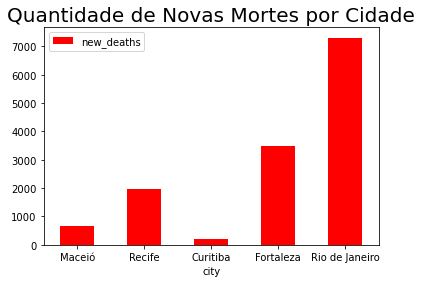

In [4]:
from matplotlib import pyplot as plt

conn = psycopg2.connect("user=postgres password=19213123 port=5432")
conn.set_isolation_level(ISOLATION_LEVEL_AUTOCOMMIT)
cursor = conn.cursor()

casos_covid = pd.read_sql_query('''
select * from casos_covid cc
join localizacao l on l.casos_covid_idcasos_covid = cc.idcasos_covid
''', con=conn)

casos_covid['date'] = pd.to_datetime(casos_covid['date'])
casos_covid['casos_covidcol'] = pd.to_datetime(casos_covid['casos_covidcol'])

casos_covid = casos_covid.rename(columns={'casos_covidcol': 'last_available_date'})
casos_covid = casos_covid.astype({
    'last_available_deaths':'int64',
    'last_available_death_rate':'float64'
    })

CIDADES = ['Curitiba', 'Recife', 'Fortaleza', 'Maceió', 'Rio de Janeiro']
casos_covid = casos_covid.query('city in @CIDADES')

df1 = casos_covid[['city', 'estimated_population_2019']].drop_duplicates().sort_values('estimated_population_2019')
df2 = casos_covid.groupby('city')['new_deaths'].sum().sort_index().to_frame()

total_novas_mortes = pd.merge(df1, df2, on=['city'])
total_novas_mortes['porcentagem'] = total_novas_mortes['new_deaths'] / total_novas_mortes['estimated_population_2019'] * 100

total_novas_mortes.plot.bar(x='city', y='new_deaths', rot=0, color = 'red')
plt.title('Quantidade de Novas Mortes por Cidade', fontsize=20)

plt.savefig('total_novas_mortes.png')  

<ipython-input-9-7d78899672f2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfTrab['idcasos_covid'] = dfTrab.index
<ipython-input-9-7d78899672f2>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfTrab['casos_covid_idcasos_covid'] = dfTrab['idcasos_covid']
<ipython-input-9-7d78899672f2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

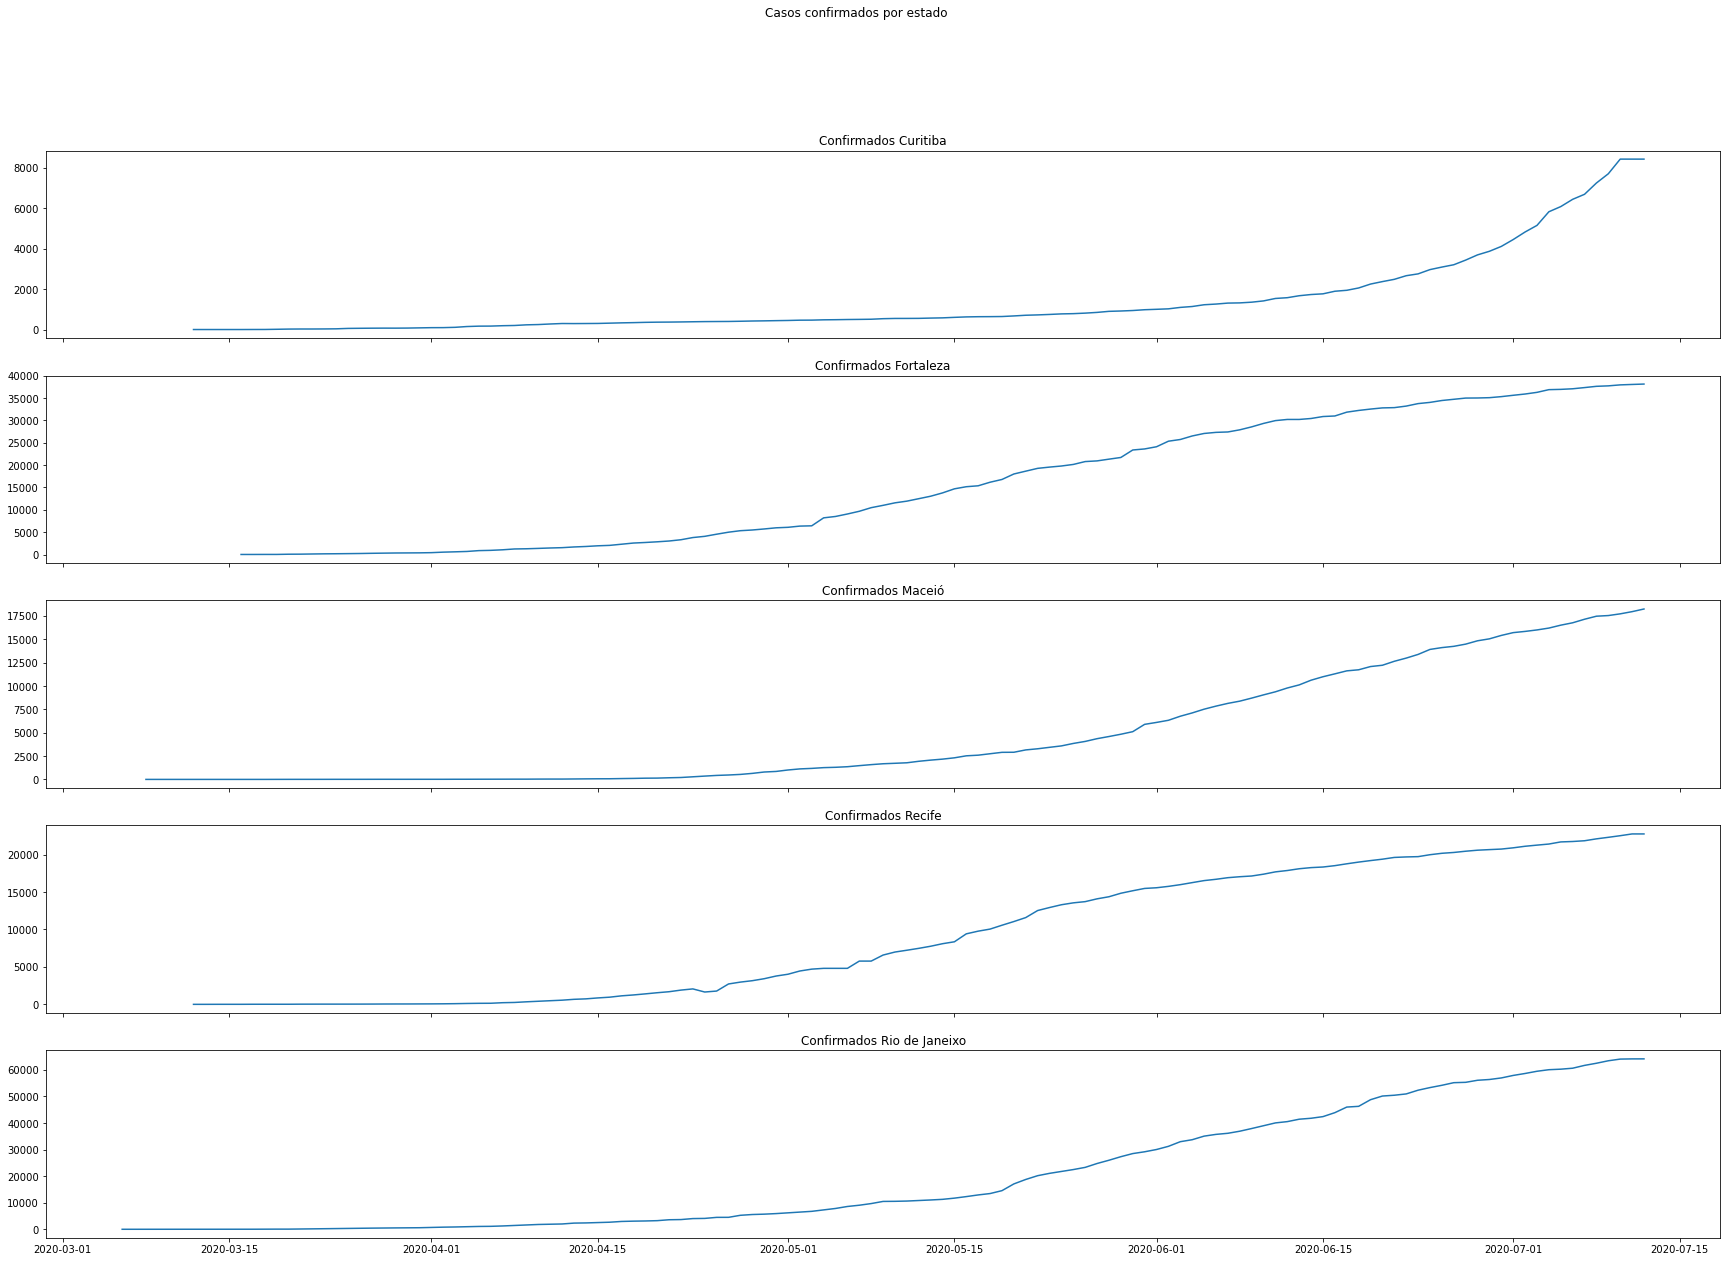

In [9]:
import pandas as pd
from matplotlib import pyplot as plt

dfTrab = df[df['city'].isin(['Curitiba', 'Fortaleza', 'Maceió', 'Recife', 'Rio de Janeiro'])]
dfTrab['idcasos_covid'] = dfTrab.index
dfTrab['casos_covid_idcasos_covid'] = dfTrab['idcasos_covid']

dfTrab['date'] = pd.to_datetime(dfTrab['date'] )

fig, axes = plt.subplots(5, 1, sharex=True)

Curitiba = dfTrab[dfTrab['city'] =='Curitiba']
Fortaleza = dfTrab[dfTrab['city'] =='Fortaleza']
Maceió = dfTrab[dfTrab['city'] =='Maceió']
Recife = dfTrab[dfTrab['city'] =='Recife']
Rio_de_Janeiro = dfTrab[dfTrab['city'] =='Rio de Janeiro']

plt.rcParams['figure.figsize'] = [30, 20]
axes[0].plot(Curitiba['date'], Curitiba['last_available_confirmed'])
axes[1].plot(Fortaleza['date'], Fortaleza['last_available_confirmed'])
axes[2].plot(Maceió['date'], Maceió['last_available_confirmed'])
axes[3].plot(Recife['date'], Recife['last_available_confirmed'])
axes[4].plot(Rio_de_Janeiro['date'], Rio_de_Janeiro['last_available_confirmed'])

axes[0].set_title("Confirmados Curitiba")
axes[1].set_title("Confirmados Fortaleza")
axes[2].set_title("Confirmados Maceió")
axes[3].set_title("Confirmados Recife")
axes[4].set_title("Confirmados Rio de Janeixo")

fig.suptitle("Casos confirmados por estado")

plt.savefig('fig.png')  

<ipython-input-7-0d906cc92467>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfTrab['idcasos_covid'] = dfTrab.index
<ipython-input-7-0d906cc92467>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfTrab['casos_covid_idcasos_covid'] = dfTrab['idcasos_covid']
<ipython-input-7-0d906cc92467>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

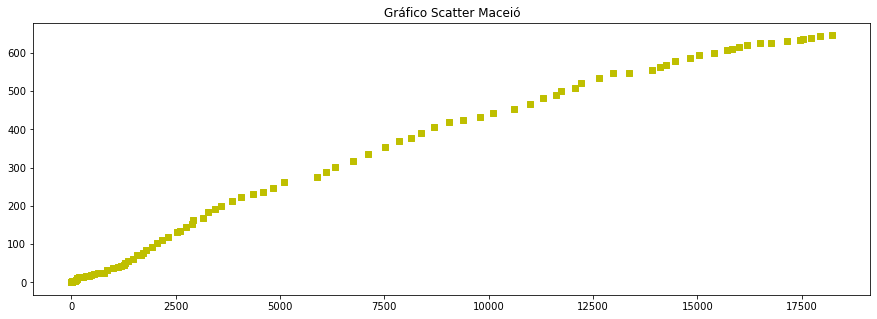

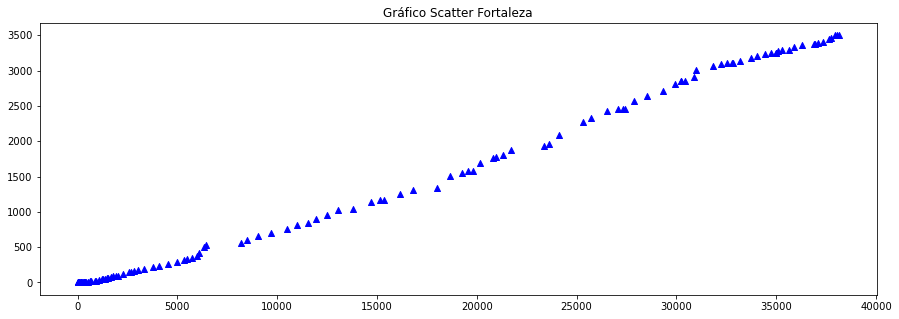

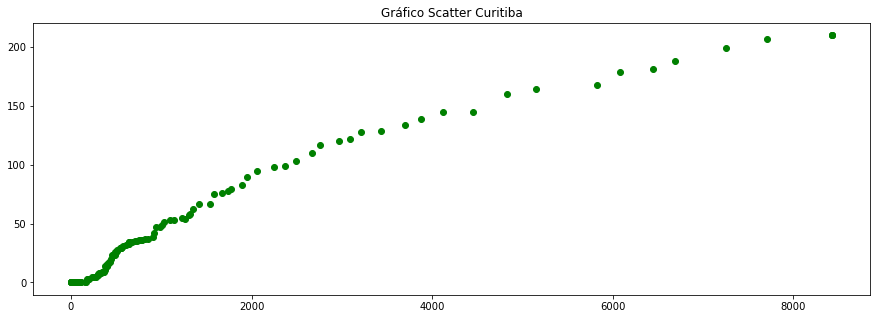

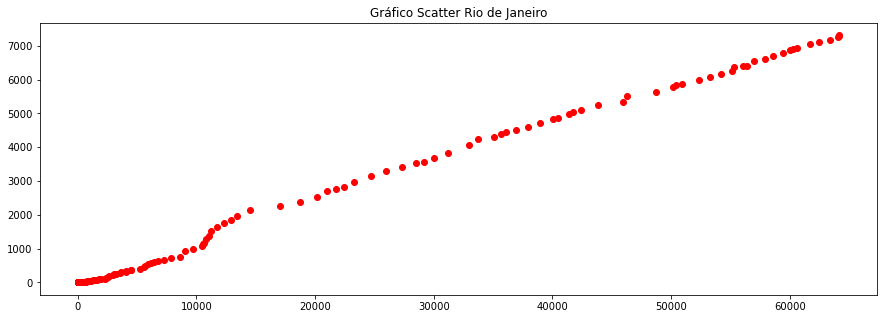

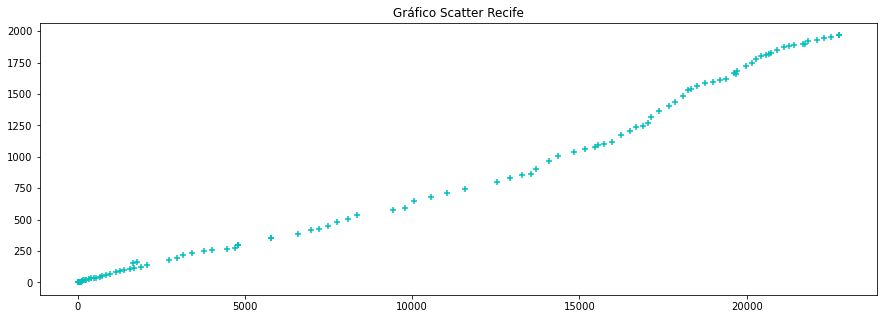

In [7]:
from matplotlib import pyplot as plt
import math
import numpy as np

dfTrab = df[df['city'].isin(['Curitiba', 'Fortaleza', 'Maceió', 'Recife', 'Rio de Janeiro'])]
dfTrab['idcasos_covid'] = dfTrab.index
dfTrab['casos_covid_idcasos_covid'] = dfTrab['idcasos_covid']

dfTrab['date'] = pd.to_datetime(dfTrab['date'] )

curitiba = (dfTrab['city'] =='Curitiba')
fortaleza = (dfTrab['city'] =='Fortaleza')
maceió = (dfTrab['city'] =='Maceió')
recife = (dfTrab['city'] =='Recife')
rio_de_janeiro = (dfTrab['city'] =='Rio de Janeiro')

Y_CR = Curitiba['last_available_deaths']
X_CR = Curitiba['last_available_confirmed']

Y_FO = Fortaleza['last_available_deaths']
X_FO = Fortaleza['last_available_confirmed']

Y_MA = Maceió['last_available_deaths']
X_MA = Maceió['last_available_confirmed']

Y_RE = Recife['last_available_deaths']
X_RE = Recife['last_available_confirmed']

Y_RJ = Rio_de_Janeiro['last_available_deaths']
X_RJ = Rio_de_Janeiro['last_available_confirmed']

plt.rcParams['figure.figsize'] = [15, 5]
fig, maceio = plt.subplots(1, 1)
fig, fortaleza = plt.subplots(1, 1)
fig, curitiba = plt.subplots(1, 1)
fig, rio = plt.subplots(1, 1)
fig, recife = plt.subplots(1, 1)

maceio.scatter(X_MA, Y_MA, color='y', marker='s')
maceio.set_title("Gráfico Scatter Maceió")

recife.scatter(X_RE, Y_RE, color='c', marker='+')
recife.set_title("Gráfico Scatter Recife")

rio.scatter(X_RJ, Y_RJ, color='r', marker='o')
rio.set_title("Gráfico Scatter Rio de Janeiro")

curitiba.scatter(X_CR, Y_CR, color='g', marker='o')
curitiba.set_title("Gráfico Scatter Curitiba")

fortaleza.scatter(X_FO, Y_FO, color='b', marker='^')
fortaleza.set_title("Gráfico Scatter Fortaleza")

plt.savefig('Recife_Scatter.png')  